<a href="https://colab.research.google.com/github/vdnghia03/Deep-Learning/blob/main/DL7_1_Text_2_Vec_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TEXT TO VECT EMBEDDING

### Xây dựng tập Vocab

In [1]:
# Import thư viện
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd


In [2]:
# Danh sách câu sentence

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

In [4]:
# Xây dựng tập vocab với 20 từ (thật ra chỉ có 10 từ vì tập sentences rất nhỏ - Add thêm OOV)
tokenizer = Tokenizer(num_words = 20, oov_token="<OOV>")


In [5]:
# Fit vào dữ liệu
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

In [6]:
word_index

{'<OOV>': 1,
 'my': 2,
 'love': 3,
 'dog': 4,
 'i': 5,
 'you': 6,
 'cat': 7,
 'do': 8,
 'think': 9,
 'is': 10,
 'amazing': 11}

In [7]:
# Sentences mới để xây dựng vec sequence
new_sentences = [
    'I really love my dog',
    'my dog loves Hana'
]

In [8]:
new_sequences = tokenizer.texts_to_sequences(new_sentences)

In [9]:
new_sequences

[[5, 1, 3, 2, 4], [2, 4, 1, 1]]

In [10]:
# Thêm padding vào, vì ta cần các câu với số lượng word cố định để đưa vào mô hình
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
# Tối đa 6 từ cho 1 câu, nếu dư thì cắt bớt, thiếu thì thêm padding = 0 vào cuối câu
padding_sequences = pad_sequences(new_sequences, maxlen=6, padding='post')

In [12]:
padding_sequences

array([[5, 1, 3, 2, 4, 0],
       [2, 4, 1, 1, 0, 0]], dtype=int32)

### Xây model với nhiều layer trong đó có layer embedding

In [14]:
output_dim = 128
vocab_size = 20

sequence_length = 6 # Vì maxlen = 6 cố định

e_layer = layers.Embedding(vocab_size, output_dim) # input_length=6 -> đầu ra là (20,128)

# Layer 0
inputs = tf.keras.Input(shape=(sequence_length,), dtype = 'int64') # input = (6,) vì sequence length = 6

# Layer 1: embedding layer
x = e_layer(inputs)

# Layer 2: Flatten
x = layers.Flatten()(x)

# Layer 3: Dence
predictions = layers.Dense(1, activation='sigmoid', name = 'predictions')(x)

# Model
model = tf.keras.Model(inputs, predictions)
model.summary()
model.compile(
              loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam() ,
              metrics=[tf.keras.metrics.BinaryAccuracy()]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 6, 128)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
print(model.layers[1].weights[0].shape)

(20, 128)


In [16]:
print(model.layers[1].weights[0])

<Variable path=embedding_1/embeddings, shape=(20, 128), dtype=float32, value=[[-0.03070064 -0.03749231  0.02403182 ...  0.03743184 -0.00222855
  -0.0364945 ]
 [-0.03324934 -0.00848492  0.00045881 ...  0.00797651  0.00658379
  -0.04851124]
 [ 0.01189717 -0.04580468  0.00404425 ...  0.03964866  0.00114404
  -0.03242461]
 ...
 [-0.01532651 -0.02405487  0.01086535 ...  0.03480408  0.00647314
   0.04265371]
 [-0.0377664  -0.02654765  0.04206758 ... -0.03756907  0.00816606
  -0.03107901]
 [-0.04384812 -0.03846537  0.02874727 ... -0.03090881  0.00954745
  -0.00511032]]>


In [17]:
e = model.layers[1]
weight = e.get_weights()[0]
weight.shape

(20, 128)

In [18]:
import io
import string

out_vec = io.open('vecs.tsv', 'w', encoding='utf-8')
out_word = io.open('words.tsv', 'w', encoding='utf-8')

for word_num in range(1, 11):
  word = tokenizer.index_word[word_num]
  embeddings = weight[word_num]
  out_word.write(word + "\n")
  out_vec.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_vec.close()
out_word.close()

# Áp dụng vào tập dữ liệu IMDB

In [19]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
# Only consider 20k
vocab_size = 10000

# Only consider the first 500 words of each movie review
maxlen = 500

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
25000 Training sequences
25000 Validation sequences


In [21]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

In [22]:
embedding_dim = 128

inputs = keras.Input(shape=(500,), dtype="int64")

# Embedding
x = layers.Embedding(vocab_size, embedding_dim)(inputs)

# Flatten and Dense
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
predictions = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, predictions)
model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    65,537,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,948,353 (255.39 MB)

 Trainable params: 66,948,353 (255.39 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.7224 - loss: 0.5697 - val_accuracy: 0.8753 - val_loss: 0.2979
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9719 - loss: 0.0877 - val_accuracy: 0.8527 - val_loss: 0.4011
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9944 - loss: 0.0157 - val_accuracy: 0.8474 - val_loss: 0.6264
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 0.8545 - val_loss: 0.7713
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9974 - loss: 0.0087 - val_accuracy: 0.8467 - val_loss: 0.7901
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9940 - loss: 0.0173 - val_accuracy: 0.8513 - val_loss: 0.7169
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 0.8453 - val_loss: 0.9002
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9978 - loss: 0.0061 - 

Text(0.5, 0, 'epoch')

<Figure size 1000x1000 with 0 Axes>

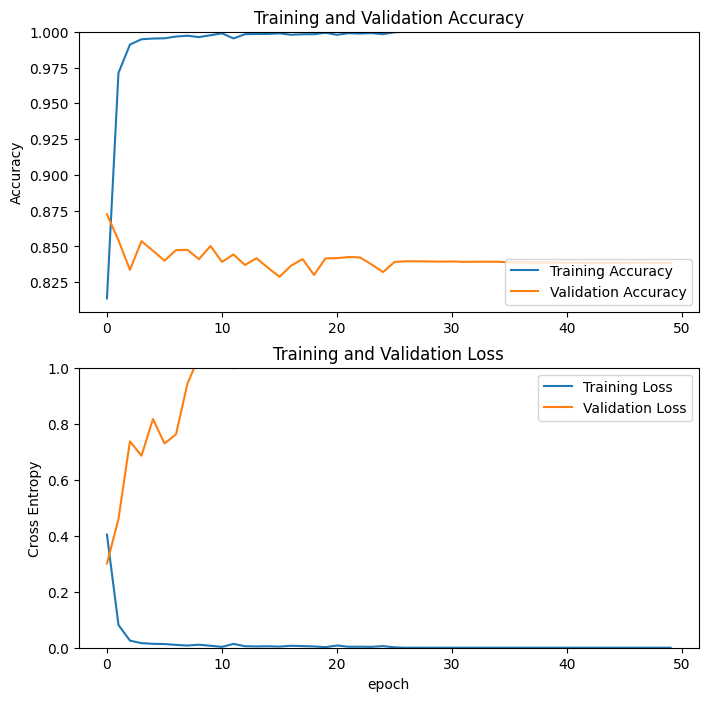

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))


history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')




In [ ]:
test_sequences = ["I love this movie"]

test_seq = tokenizer.texts_to_sequences(test_sequences)
test_seq = keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=maxlen)

model.predict(test_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


array([[1.]], dtype=float32)